## Mixed state entanglement with the $p_3$-PPT condition

A quantum state described by a density matrix $\rho$ is said to be entangled when $\rho_{AB}\neq \sum_i p_i\rho_A^{(i)}\otimes \rho_B^{(i)}$ ($p_i\ge 0$). 

In [Elben et al, PRL 2020](https://link.aps.org/doi/10.1103/PhysRevLett.125.200501), an experimental protocol based on randomized measurements was proposed to detected such mixed-state entanglement. 



In [1]:
using RandomMeas

First, we consider an $N$-qubit state $\ket{\psi}$. We will consider the entanglement of $\rho_{AB}$ where $A$ and $B$ are two partitions of the $N$-qubit system. 

In [2]:
N  = 6
χ = 2^(N÷2)
ξ = siteinds("Qubit", N)
ψ = random_mps(ξ; linkdims=χ);

The $p_3$-PPT condition is a consequence of the [positive partial transpose (PPT) condition](https://en.wikipedia.org/wiki/Peres%E2%80%93Horodecki_criterion). 

If $\rho_{AB}$ is separable not entangled, then the positive partial transpose density matrix $\rho_{AB}^{T_A}$, where $T_A$ denotes the partial tranposition with respect to A, is positive semi-definite (PSD). 

The $p_3$ PPT condition states that if $\rho_{AB}^{T_A}$ is PSD then $C_3=p_2^2/p_3\le 1$, where $p_n=\mathrm{Tr}([\rho_{AB}^{T_A}]^n)$ are called PT moments, and are experimentally accessible with randomized measurements.

This can be turn in an experimental method to detect entanglement: If we measure $C_3>1$, this means that  $\rho_{AB}^{T_A}$ is not PSD, and therefore that $A$ and $B$ are entangled.

To illustrate this result, let us first evaluate numerically $C_3$ for various partitions $AB$

In [3]:
p = zeros(N,2)
C3 = zeros(N÷2)
ITensors.disable_warn_order()
@showprogress dt=1 for NA in 1:N÷2
    #We consider partitions AB with |A|=|B|
    NAB = 2*NA
    #We build the reduced density matrix on the first N_AB qubits as a ITensor object
    ρ = reduce_to_subsystem(ψ,collect(1:NAB))
    #We take the partial transpose on the first NA qubits
    ρT = partial_transpose(ρ,collect(1:NA))
    #We compute the first two PT moments and evalute the p3ppt criterion
    p2, p3 = get_trace_moments(ρT,[2,3])
    @show C3[NA] = p2^2/p3
end

C3[NA] = p2 ^ 2 / p3 = 0.8106430248382404
C3[NA] = p2 ^ 2 / p3 = 1.1411570075376687


Progress:  67%|███████████████████████████▍             |  ETA: 0:01:26

C3[NA] = p2 ^ 2 / p3 = 5.899475100186061

Progress: 100%|█████████████████████████████████████████| Time: 0:03:11


We see that $C_3>1$ when $N_A$ is sufficiently large, which shows that entanglement can be experimentally detected using the PPT condition. 

Let us now simulate the corresponding experimental protocol. First, we acquire randomized measurements sampled with random unitaries. 

In [4]:
NU=1000
NM=1000
measurement_group = MeasurementGroup(ψ,NU,NM;mode="dense");


We can now access partial-transpose moments using classical shadows. In contrast to the first experimental measurement performed in [Elben et al, PRL 2020](https://link.aps.org/doi/10.1103/PhysRevLett.125.200501), let use here batch shadows that correspond to simpler postprocessing codes [Rath et al, PRX quantum 2023](https://doi.org/10.1103/PRXQuantum.4.010318).

In [5]:
C3s = zeros(N÷2)
n = 10 #number of batch shadows
@showprogress dt=1 for NA in 1:N÷2
    NAB = 2*NA

    #We first form batch shadows
    reduced_group = reduce_to_subsystem(measurement_group,collect(1:NAB))
    ρs = get_dense_shadows(reduced_group,number_of_ru_batches=n)
    ρs = partial_transpose(ρs,collect(1:NA))

    ξAB = ξ[1:NAB]
    #We access the moments via U-statistics
    p = get_trace_moments(ρs, [2,3])
    #and compute the p_3 PPT condition
    C3s[NA] = p[1]^2/p[2]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:20


In [6]:
@show C3s
@show C3

C3s = [0.8149822537622637, 1.1442460572674917, 5.919023986291069]
C3 = [0.8106430248382404, 1.1411570075376687, 5.899475100186061]


3-element Vector{Float64}:
 0.8106430248382404
 1.1411570075376687
 5.899475100186061

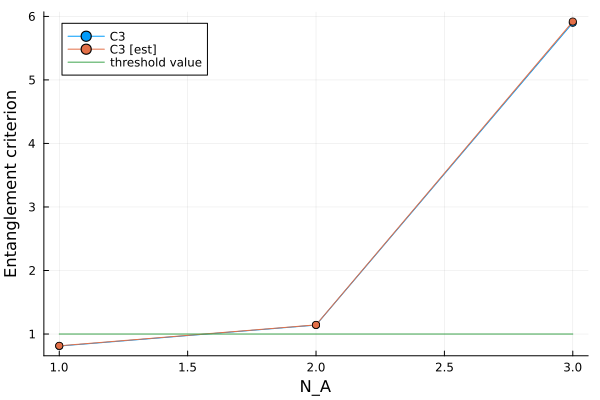

In [7]:
using Plots
Plots.plot(1:N÷2,C3,marker=:circle,label="C3")
Plots.plot!(1:N÷2,C3s,marker=:circle,label="C3 [est]")
Plots.plot!(1:N÷2,ones(N÷2),label="threshold value")
xlabel!("N_A")
ylabel!("Entanglement criterion")